In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.normal import Normal
from torch.autograd import Variable

In [ ]:
class Actor_Network(nn.Module):
    """
    Gaussian Policy
    Outputs means and std deviation of a gaussian policy
    """
    def __init__(self, input_layer, output_layer):
        super(Actor_Network,self).__init__()
        self.linear1 = nn.Linear(input_layer,32)
        self.linear2 = nn.Linear(32,128)
        self.linear3 = nn.Linear(128,32)
        self.linear4 = nn.Linear(32,output_layer)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        #x = F.relu(self.linear4(x))
        linear_out = self.linear4(x)
        #s = nn.Softplus()
        #x = s(linear_out)
        #print(linear_out)
        linear_out[1] = F.relu(linear_out[1])+0.00001
        #print(linear_out)

        return linear_out
        #return x

class Critic_Network(nn.Module):
    """
    Outputs Value Function
    """
    def __init__(self,input_layer):
        super(Critic_Network,self).__init__()
        self.linear1 = nn.Linear(input_layer,32)
        self.linear2 = nn.Linear(32,128)
        self.linear3 = nn.Linear(128,32)
        self.linear4 = nn.Linear(32,1)
        

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [ ]:
class ReplayMemory():
    def __init__(self,size):
        self.size = size
        #state, action, rew, next_state, done
        self.memory = [[],[],[],[],[]]
    def store(self,data):
        if len(self.memory[0])==self.size:
            for idx in range(5):
                self.memory[idx].pop(0)
        for idx,part in enumerate(data):
            self.memory[idx].append(part)
    def sample(self,batch_size):
        rows = random.sample(range(0,len(self.memory[0])),batch_size)
        experiences = [[],[],[],[],[]]
        for row in rows:
            for col in range(5):
                experiences[col].append(self.memory[col][row])
        return experiences

    def __len__(self):
        return len(self.memory[0])

In [ ]:
if(torch.cuda.is_available()):
    print('CUDA Available')
device = torch.device('cuda')

CUDA Available


In [ ]:
#actor = Actor_Network(2,2).to(device)

#print(actor(torch.FloatTensor([5,6])), actor(torch.FloatTensor([5,6])).detach().numpy().squeeze())


env = gym.make('Pendulum-v0')
actor_model = Actor_Network(3,2).to(device)
critic_model = Critic_Network(3).to(device)
critic_target_model = Critic_Network(3).to(device)
critic_target_model.eval()

gamma = 0.9
learning_rate = 0.0005
critic_optimizer = torch.optim.Adam(critic_model.parameters(),lr=learning_rate)
actor_optimizer = torch.optim.Adam(actor_model.parameters(),lr=learning_rate)

memory = ReplayMemory(5000)
BATCH_SIZE = 64

In [ ]:
def train_critic():
    #print(len(memory))
    if len(memory)<BATCH_SIZE:
        return 0
    experiences = memory.sample(BATCH_SIZE)
    
    state_batch = np.array(experiences[0])
    state_batch = torch.Tensor(state_batch).to(device)

    #action_batch = torch.Tensor(experiences[1])  # .unsqueeze(1)
    reward_batch = np.array(experiences[2])
    reward_batch = torch.Tensor(reward_batch)

    next_state_batch = np.array(experiences[3])
    next_state_batch = torch.Tensor(next_state_batch).to(device)
    done_batch = experiences[4]

    predicted_Vs = critic_model(state_batch)
    predicted_Vs = predicted_Vs.reshape(BATCH_SIZE)
    with torch.no_grad():
        target_Vns = critic_target_model(next_state_batch.to(device)).cpu()

    target_Vs = torch.zeros(BATCH_SIZE).to(device)
    for i,is_done in enumerate(done_batch):
        if is_done:
            target_Vs[i] = reward_batch[i]
        else:
            target_Vs[i] = reward_batch[i] + gamma*target_Vns[i]
    
    critic_optimizer.zero_grad()
    loss = nn.MSELoss()
    critic_loss = loss(predicted_Vs,target_Vs)
    #print(critic_loss)
    #print('predicted_Vs',predicted_Vs)
    #print('target_Vs',target_Vs)

    critic_loss.backward()
    critic_optimizer.step()
    return critic_loss

In [ ]:
def train_actor(step_data):
    state = step_data[0]
    action = step_data[1]
    rew = step_data[2]
    new_state = step_data[3]

    with torch.no_grad():
        Vs = critic_model(torch.FloatTensor(state).to(device))
        Vns = critic_model(torch.FloatTensor(new_state).to(device))
    act_val = torch.from_numpy(np.array(rew)).float().to(device) + gamma*Vns - Vs

    dist_param = actor_model(torch.FloatTensor(state).to(device))
    #if dist_param[1] <= 0:
    #    dev = 0.0001
    #else:
    #    dev = dist_param[1]
    dist = Normal(dist_param[0],dist_param[1])

    actor_optimizer.zero_grad()
    actor_loss = -dist.log_prob(torch.from_numpy(action).float().to(device))*act_val

    actor_loss.backward()
    actor_optimizer.step()
    return actor_loss

model_changed..
0 -859.262810842738
1 -1675.8493342618217
2 -1069.7071672157972
3 -1842.5100422050907
4 -1763.8861050453704
5 -1591.47847695624
6 -743.1949531866867
7 -1510.3625445096295
8 -1477.451801086452
9 -1074.3869481288978
10 -1652.5485749991399
11 -1824.9267533100017
12 -1437.199775272934
13 -1042.4618598043546
14 -1517.4525642378646
15 -1525.0239188651194
16 -1726.9495491263176
17 -1181.5594235281105
18 -1037.2787479193853
19 -992.2708222432041
20 -1142.6840886090492
21 -1787.0048468868818
22 -888.1716269956055
23 -1490.0798425397707
24 -847.1468212981089
25 -1587.3167705914866
26 -1297.371041112738
27 -1159.6777725796214
28 -1262.7762030288516
29 -1061.1944195978529
30 -1146.4186298079874
31 -871.7973815139381
32 -1427.915130898322
33 -963.5874073447183
34 -1002.0820030953399
35 -1179.8921993252045
36 -1268.5852123658474
37 -1164.5813602357136
38 -1185.4194987098988
39 -1344.8069306169932
40 -1180.365489541117
41 -1234.8773217388916
42 -1338.8545694909276
43 -1796.72056395768

AttributeError: ignored

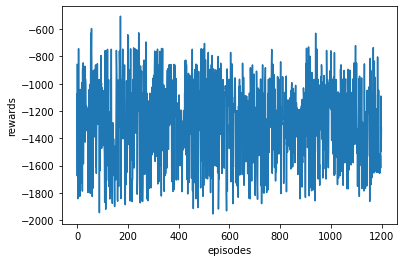

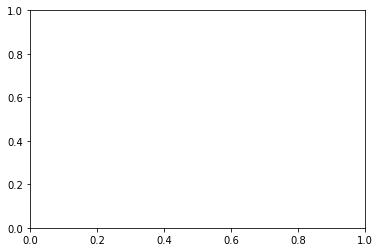

In [ ]:
change_model_after = 75
rew_list = []
critic_loss_list = []
actor_loss_list = []
for ep in range(1200):
    state = env.reset()
    if ep%change_model_after==0:
        print('model_changed..')
        critic_target_model.load_state_dict(critic_model.state_dict())
    #print('state', state)
    done = False
    total_rew = 0
    while not done:

        with torch.no_grad():
            dist_param = actor_model(torch.from_numpy(state).float().to(device))
           #if dist_param[1] <= 0:
           #     dist_param[1] = 0.0001
            dist = Normal(dist_param[0], dist_param[1])
            # action = dist.sample().item()
            action = dist.sample().cpu().numpy().reshape(1)
            apply_action = 2*action
            # print(state)
            # print(dist_param)
        new_state, rew, done, info = env.step(apply_action)

        total_rew += rew

        memory.store([state,action,rew,new_state,done])
        critic_loss = train_critic()
        actor_loss = train_actor([state,action,rew,new_state])
        critic_loss_list.append(critic_loss)
        #print(critic_loss)
        actor_loss_list.append(actor_loss)
    print(ep,total_rew)
    rew_list.append(total_rew)
    #print(critic_loss,actor_loss)


fig1,ax1 = plt.subplots()
x = np.arange(len(rew_list))
ax1.plot(x,rew_list)
ax1.set_xlabel('episodes')
ax1.set_ylabel('rewards')
fig1loss,ax1loss = plt.subplots()
x_loss = np.arange(len(critic_loss_list))
critic_loss_list.cpu()
ax1loss.plot(x_loss,critic_loss_list)
ax1loss.set_xlabel('steps')
ax1loss.set_ylabel('loss')
plt.show()

TypeError: ignored

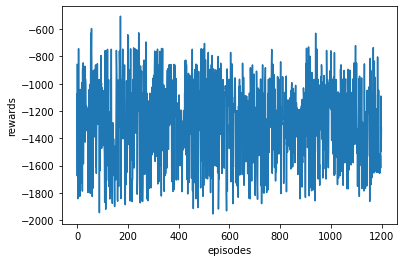

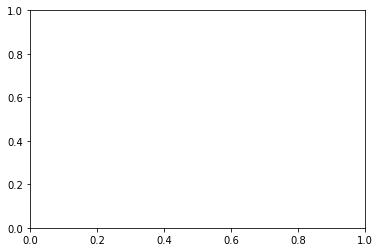

In [ ]:
fig1,ax1 = plt.subplots()
x = np.arange(len(rew_list))
ax1.plot(x,rew_list)
ax1.set_xlabel('episodes')
ax1.set_ylabel('rewards')
fig1loss,ax1loss = plt.subplots()
x_loss = np.arange(len(critic_loss_list))
ax1loss.plot(x_loss,critic_loss_list)
ax1loss.set_xlabel('steps')
ax1loss.set_ylabel('loss')
fig_al, ax_al = plt.subplots()
x_aloss = np.arange(len(actor_loss_list))
ax_al.plot(x_aloss,actor_loss_list)
ax_al.set_xlabel('steps')
ax_al.set_ylabel('loss')

plt.show()

In [ ]:
print('Testing...')

def test_model():
    
    critic_model.eval()
    actor_model.eval()
    test_rew_list = []
    for ep in range(100):
        test_total_rew = 0
        done = False
        state = env.reset()
        while not done:
            with torch.no_grad():
                state = torch.FloatTensor(state).cpu().to(device)
                dist_param = actor_model(state)
                dist = Normal(dist_param[0],dist_param[1])
                action = dist.sample().cpu().numpy().reshape(1)
            new_state, rew, done,_ = env.step(action)
            test_total_rew+=rew
            state = new_state
        test_rew_list.append(test_total_rew)
    return test_rew_list

Testing...


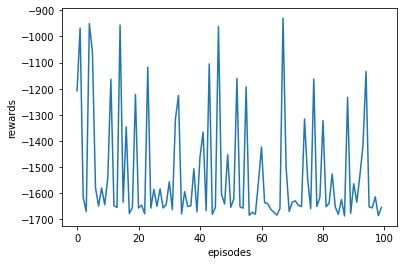

In [ ]:
test_rew = test_model()

fig2,ax2 = plt.subplots()
x2 = np.arange(len(test_rew))
ax2.plot(x2,test_rew)
ax2.set_xlabel('episodes')
ax2.set_ylabel('rewards')
plt.show()